# Predictive Analytics: Simple Demand Forecast
**Learning goals**
- Create a daily demand series with seasonality and promotions.
- Engineer simple features (DoW, lag) and fit a linear model.
- Compare actual vs predicted and run a quick what-if.

> No external data needed.


In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
rng = np.random.default_rng(123)

# Simulate demand
days = pd.date_range("2025-01-01", periods=180, freq="D")
dow = days.dayofweek.values  # 0=Mon
base = 200 + 20*np.sin(2*np.pi*np.arange(len(days))/7)  # weekly seasonality
promo = rng.choice([0,1], size=len(days), p=[0.8,0.2])
noise = rng.normal(0,10,size=len(days))
demand = (base + 50*promo + noise).round(0).astype(int)
df = pd.DataFrame({"Date":days,"Demand":demand,"Promo":promo})
df["DoW"] = dow

# lag feature
df["Lag1"] = df["Demand"].shift(1)
df = df.dropna().reset_index(drop=True)

# Train/test split
train = df.iloc[:-30].copy()
test  = df.iloc[-30:].copy()
Xtr = train[["Promo","DoW","Lag1"]]; ytr = train["Demand"]
Xte = test[["Promo","DoW","Lag1"]];  yte = test["Demand"]

# Fit model
model = LinearRegression().fit(Xtr, ytr)
test["Pred"] = model.predict(Xte)
mae = mean_absolute_error(yte, test["Pred"])
print(f"MAE on holdout: {mae:.1f}")

MAE on holdout: 15.4


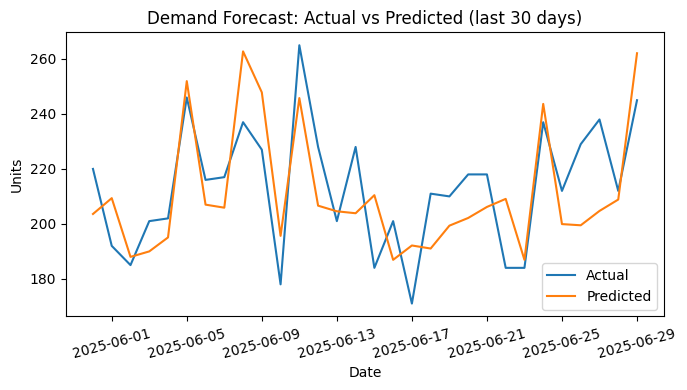

In [2]:
# Plot Actual vs Predicted
plt.figure(figsize=(7,4))
plt.plot(test["Date"], yte.values, label="Actual")
plt.plot(test["Date"], test["Pred"].values, label="Predicted")
plt.title("Demand Forecast: Actual vs Predicted (last 30 days)")
plt.xlabel("Date"); plt.ylabel("Units")
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [3]:
# What-if: With and without promo tomorrow
tomorrow = pd.DataFrame({
    "Promo":[0,1],
    "DoW":[(df["DoW"].iloc[-1]+1)%7]*2,
    "Lag1":[df["Demand"].iloc[-1]]*2
})
scen = pd.DataFrame({"Scenario":["No Promo","Promo"], "Forecast": model.predict(tomorrow).round(0)})
scen

,Scenario,Forecast
0,No Promo,195.0
1,Promo,249.0


**Discussion prompts**
- Is the model good enough for weekly planning?
- Which additional features would you add in a real retailer (holiday, price, weather)?
